# Mean-Variance Data Preparation
## 前期依賴
### 安裝函式庫
- 使用前需先安裝以下函式庫👇
  - 記得通過 `conda` 來新增一個環境

#### 安裝 Gurobi

In [ ]:
!conda config --add channels https://conda.anaconda.org/gurobi

In [ ]:
conda install gurobi

#### 安裝其他依賴

In [ ]:
conda install pandas numpy matplotlib openpyxl

### 導入 Gurobi license
- 學術可以從這裡獲取👇
  - [Free Licenses for Academics & Recent Graduates](https://www.gurobi.com/academia/academic-program-and-licenses/)
- 替換下方的 `YOUR_LICENSE_KEY` 如果已經有了就跳過

In [ ]:
import subprocess
from IPython.core.magic import register_line_magic

@register_line_magic
def grbgetkey(line):
    license_key = input("請輸入您的 Gurobi license key，然後按 Enter: ")
    
    try:
        result = subprocess.run(['grbgetkey', license_key], 
                                capture_output=True, 
                                text=True, 
                                check=True)
        print("Gurobi license key 設置成功！")
        print("命令輸出:")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print("設置 Gurobi license key 時發生錯誤。")
        print("錯誤輸出:")
        print(e.stderr)
    except FileNotFoundError:
        print("錯誤：找不到 'grbgetkey' 命令。請確保 Gurobi 已正確安裝且在系統路徑中。")

print("請在新的單元格中使用 %grbgetkey 魔法命令來設置 Gurobi license key")

In [ ]:
%grbgetkey

## 主程式

### 填寫路徑（很重要）

In [1]:
import sys
from IPython.core.magic import register_line_magic

@register_line_magic
def get_data_path(line):
    def process_path(path):
        path = path.strip()  # 移除開頭和結尾的空白字符
        if sys.platform.startswith('win'):
            return fr"{path}"
        return f"{path}"

    user_input = input("請貼上或輸入您的文件路徑，然後按 Enter: ")
    
    global data_path
    data_path = process_path(user_input)
    
    print(f"data_path 已設置為: {data_path}")
    print("現在可以繼續執行以下程式")

print("請在新的單元格中使用 %get_data_path 魔法命令來設置 data_path")


請在新的單元格中使用 %get_data_path 魔法命令來設置 data_path


In [2]:
%get_data_path

data_path 已設置為: threeassetsonly.xlsx
現在可以繼續執行以下程式


### 導入函式庫

In [3]:
import gurobipy as gp
from gurobipy import GRB  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 導入數據並進行初步處理


In [4]:
# 導入示例數據
returns = pd.read_excel(data_path)

# 計算預期報酬和協方差矩陣
expected_returns = np.mean(returns, axis=0)
cov_matrix = np.cov(returns, rowvar=False)

# 資產數量
n = len(expected_returns)

### 定義優化函數

In [5]:
def optimize_portfolio(target_return):
    # 創建Gurobi模型
    m = gp.Model('mean_variance')

    # 決策變量：投資組合權重
    weights = m.addVars(n, lb=0, ub=1, name="weights")

    # 投資組合方差 (objective function)
    portfolio_variance = sum(weights[i] * cov_matrix[i, j] * weights[j] for i in range(n) for j in range(n))
    m.setObjective(portfolio_variance, GRB.MINIMIZE)
    
    # 目標收益約束
    m.addConstr(sum(weights[i] * expected_returns[i] for i in range(n)) >= target_return, "target_return")
    PR = sum(weights[i] * expected_returns[i] for i in range(n))
    
    # 全資金約束（權重之和為1）
    m.addConstr(weights.sum() == 1, "budget")
    
    # 簡化輸出的內容
    m.setParam("OutputFlag", 0)
    # 優化模型
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        PSTD = portfolio_variance.getValue() ** 0.5
        return PSTD, PR.getValue(), [weights[i].X for i in range(n)]
    else:
        return None

### 生成數據

In [6]:
result = []
x = []
y = []

for t in range(1, 21):
    target_return = 0.005 * t
    optimization_result = optimize_portfolio(target_return)
    
    if optimization_result:
        PSTD, PR, weights = optimization_result
        result.append([PSTD, PR])
        x.append(PSTD)
        y.append(PR)
        
        print(f'目標收益: {target_return:.4f}')
        print('最佳投資組合權重:')
        for i, weight in enumerate(weights):
            print(f"資產 {i+1}: {weight:.4f}")
        print(f"投資組合標準差: {PSTD:.6f}")
        print(f"實際投資組合收益: {PR:.6f}")
        print("---")
    else:
        print(f"無法找到最佳解 (目標收益: {target_return:.4f})")

# 將結果轉換為DataFrame
result_df = pd.DataFrame(result, columns=['標準差', '收益'])
display(result_df)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-31
目標收益: 0.0050
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0100
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0150
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0200
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0250
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0300
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0350
最佳投資組合權重:
資產 1: 0.0249
資產 2: 0.0282
資產 3: 0.9468
投資組合標準差: 0.030707
實際投資組合收益: 0.039200
---
目標收益: 0.0400
最佳投資組合權重:
資產 1: 0.0323
資產 2: 0.0369
資產 3: 0.9308
投資組合標準差: 0.030753
實際投資組合收益: 0.040000
---
目標收益: 0.0450
最佳投資組合權重:
資產 1: 0.0786
資產 2: 0.0911
資產 3: 0.8304
投資組合標準差: 0.033032
實際投資組

/var/folders/9h/v4160_yj2h7700dtq3f2mfk40000gn/T/ipykernel_26898/1625408918.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.addConstr(sum(weights[i] * expected_returns[i] for i in range(n)) >= target_return, "target_return")
/var/folders/9h/v4160_yj2h7700dtq3f2mfk40000gn/T/ipykernel_26898/1625408918.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PR = sum(weights[i] * expected_returns[i] for i in range(n))


,標準差,收益
0,0.030707,0.0392
1,0.030707,0.0392
2,0.030707,0.0392
3,0.030707,0.0392
4,0.030707,0.0392
5,0.030707,0.0392
6,0.030707,0.0392
7,0.030753,0.0400
8,0.033032,0.0450
9,0.038166,0.0500


### 繪製圖案

/Users/bs10081/Developer/mv_input_return_to_out_effect_frotier/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bs10081/Developer/mv_input_return_to_out_effect_frotier/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bs10081/Developer/mv_input_return_to_out_effect_frotier/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bs10081/Developer/mv_input_return_to_out_effect_frotier/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from fon

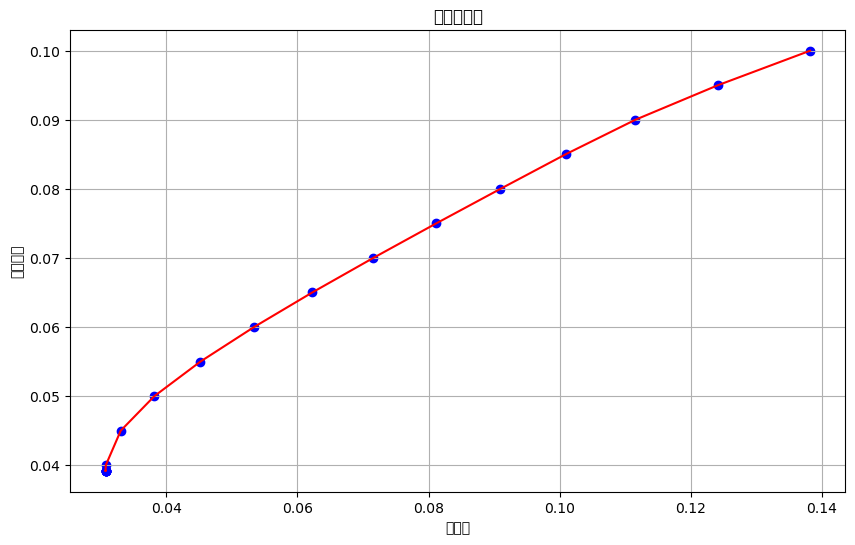

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')
plt.plot(x, y, color='red')

plt.title("有效前沿圖")
plt.xlabel("標準差")
plt.ylabel("預期收益")

plt.grid(True)
plt.show()